-----------
#### code implementation of page 76-77 from the Richard Sutton
-------------------

In [1]:
!pip install lolviz

  Using cached lolviz-1.4.4-py3-none-any.whl
  Using cached graphviz-0.19.1-py3-none-any.whl (46 kB)


In [2]:
import matplotlib.pyplot as plt                 # type: ignore
import pandas as pd                             # type: ignore

from gridWorldEnvironment import GridWorld      # type: ignore

import numpy as np                              # type: ignore 
import seaborn as sns                           # type: ignore 
from lolviz import *                            # type: ignore

In [3]:
# parameters
gamma      = 1 # discounting rate
rewardSize = -1
gridSize   = 4

terminationStates = [0, 15]

In [4]:
# creating gridworld environment
gw = GridWorld( gamma     = gamma,
                rewardSize= rewardSize,
                gridSize  = gridSize,
                )

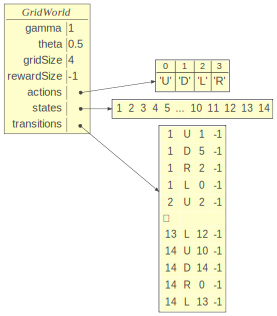

In [6]:
objviz(gw)      

In [7]:
print("Actions: ", gw.actions)
print("States: ",  gw.states)

Actions:  ('U', 'D', 'L', 'R')
States:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


#### State Transitions
- All possible state transitions in `deterministic` gridworld
- Each `transition` is a quadruple of (state, action, next state, reward)
    - For instance, first row implies that in if the agent performs action U (upwards) in state 1, it ends up at state 1 again (not moving) with -1 reward

In [8]:
gw.transitions

array([[1, 'U', 1, -1],
       [1, 'D', 5, -1],
       [1, 'R', 2, -1],
       [1, 'L', 0, -1],
       [2, 'U', 2, -1],
       [2, 'D', 6, -1],
       [2, 'R', 3, -1],
       [2, 'L', 1, -1],
       [3, 'U', 3, -1],
       [3, 'D', 7, -1],
       [3, 'R', 3, -1],
       [3, 'L', 2, -1],
       [4, 'U', 0, -1],
       [4, 'D', 8, -1],
       [4, 'R', 5, -1],
       [4, 'L', 4, -1],
       [5, 'U', 1, -1],
       [5, 'D', 9, -1],
       [5, 'R', 6, -1],
       [5, 'L', 4, -1],
       [6, 'U', 2, -1],
       [6, 'D', 10, -1],
       [6, 'R', 7, -1],
       [6, 'L', 5, -1],
       [7, 'U', 3, -1],
       [7, 'D', 11, -1],
       [7, 'R', 7, -1],
       [7, 'L', 6, -1],
       [8, 'U', 4, -1],
       [8, 'D', 12, -1],
       [8, 'R', 9, -1],
       [8, 'L', 8, -1],
       [9, 'U', 5, -1],
       [9, 'D', 13, -1],
       [9, 'R', 10, -1],
       [9, 'L', 8, -1],
       [10, 'U', 6, -1],
       [10, 'D', 14, -1],
       [10, 'R', 11, -1],
       [10, 'L', 9, -1],
       [11, 'U', 7, -1],
    

In [9]:
print(gw.state_transition(12, "U"))
print(gw.state_transition(13, "L"))

(8, -1)
(12, -1)


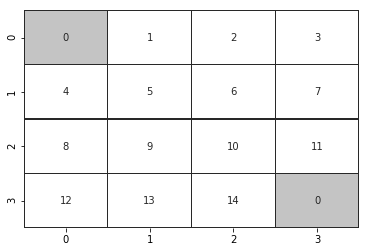

In [10]:
gw.show_environment()

#### Generate random episode
- For Monte Carlo methods, `random episodes` from `starting state` to `terminal` state should be generated in advance
    - Random episode below follows `equiprobable random policy` (i.e., same probabilities for each action)

In [11]:
def generate_random_episode(env):
    episode = []
    done    = False
    
    current_state = np.random.choice(env.states)
    
    episode.append((current_state, -1))
    
    while not done:

        action = np.random.choice(env.actions)
        
        next_state, reward = gw.state_transition(current_state, action)
        
        episode.append((next_state, reward))
        
        if next_state == 0:
            done = True
            
        current_state = next_state
        
    return episode

In [16]:
generate_random_episode(gw)

[(7, -1),
 (11, -1),
 (7, -1),
 (3, -1),
 (7, -1),
 (7, -1),
 (11, -1),
 (11, -1),
 (10, -1),
 (11, -1),
 (0, -1)]

Initialize value functions of states to 0

In [17]:
def value_array(env):
    return np.zeros(len(env.states)+2)

#### First-visit MC Prediction
- Estimates $v_\pi(s)$ as the average of the returns following first visit to $s$
    - Most widely studied (from 1940s)

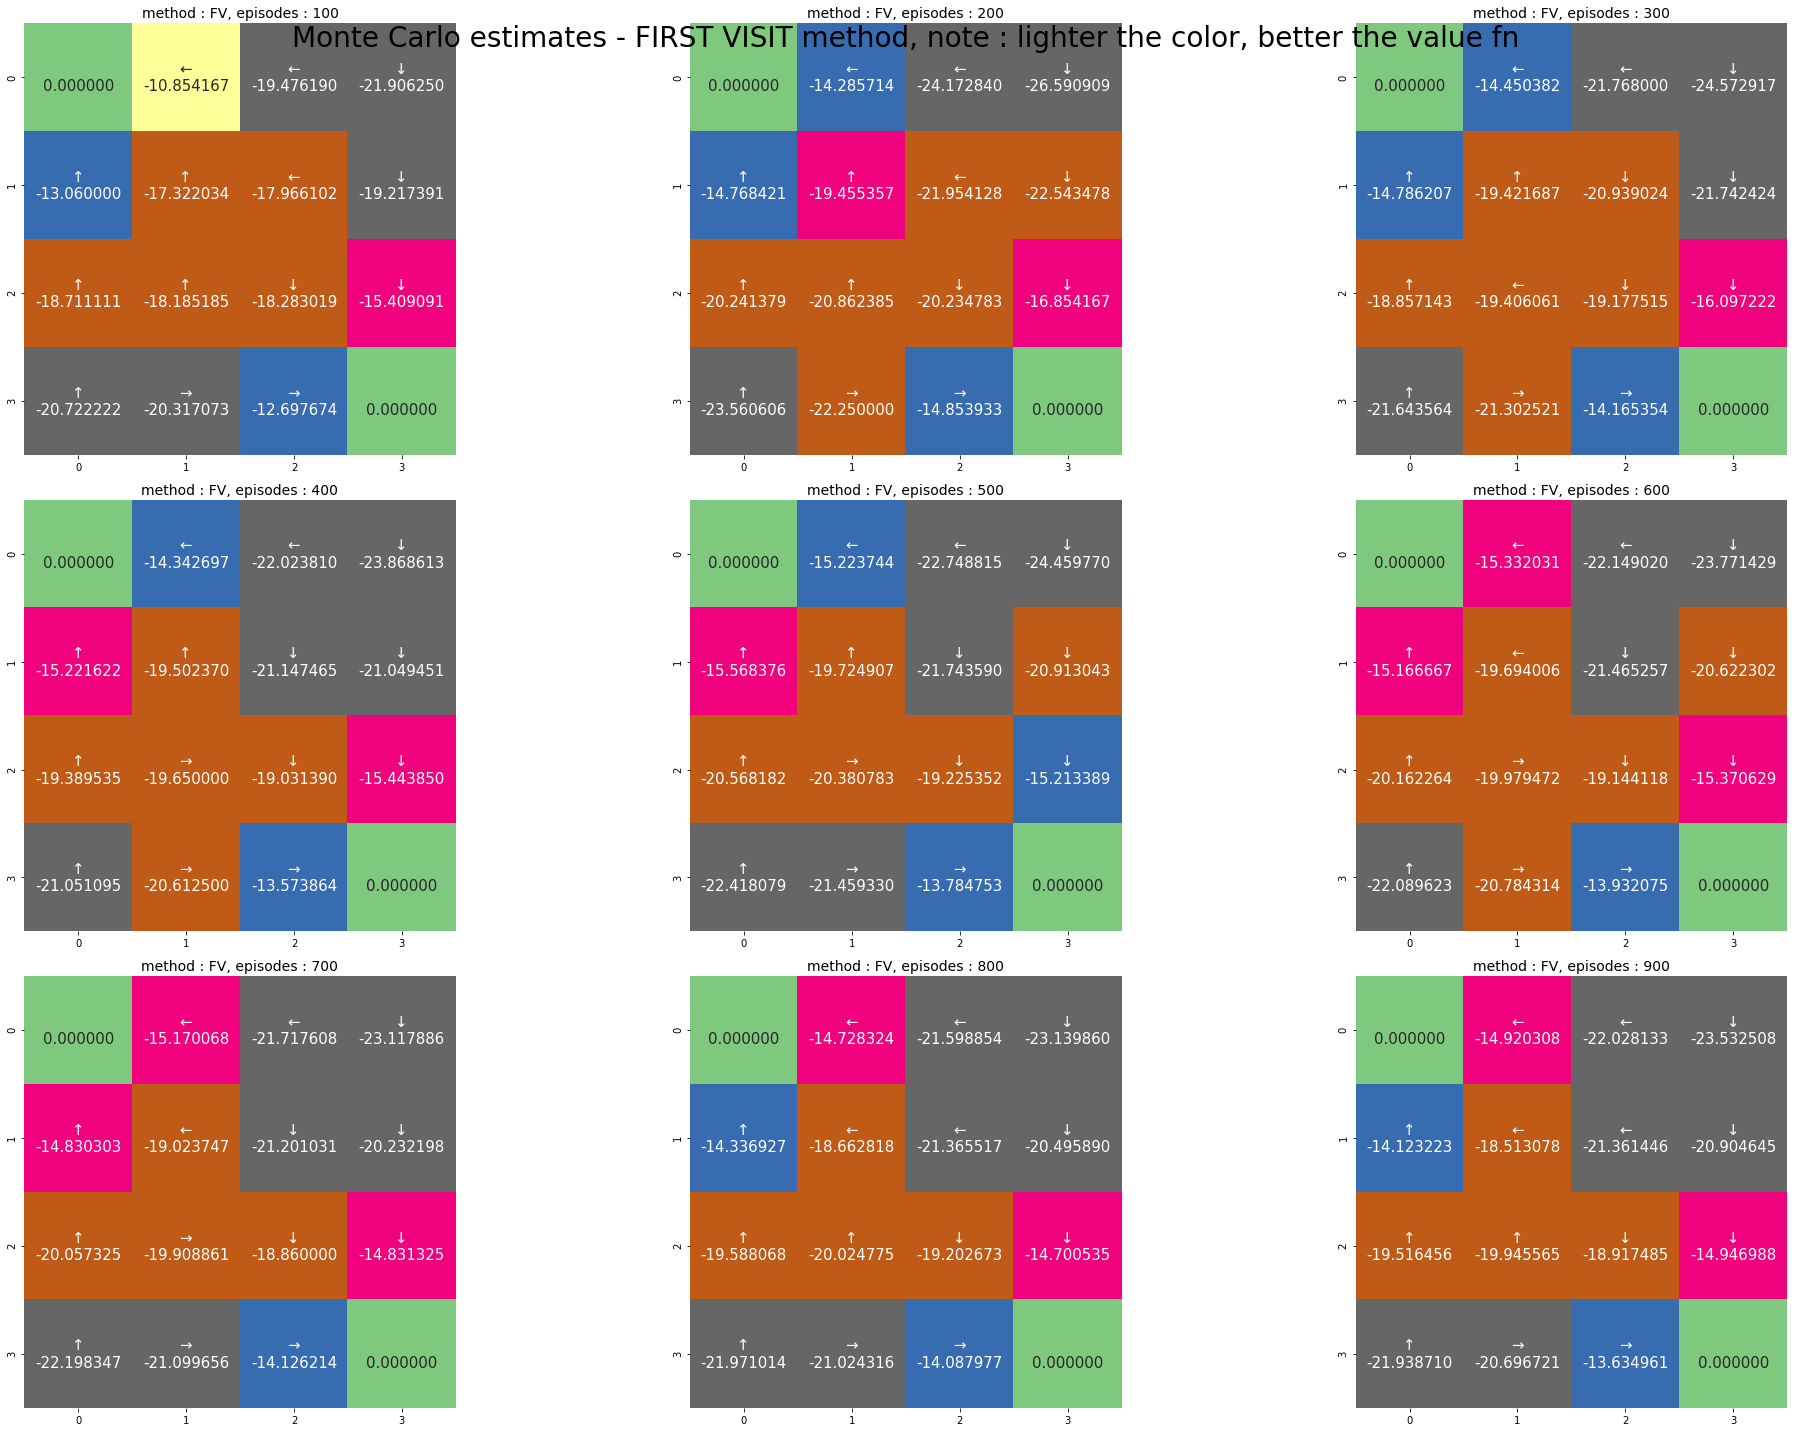

In [19]:
nbr_cycles_of_MC_run    = 9
nbr_episodes_each_cycle = 100
number_plots_per_row    = 3

FV_V = dict()

FV_policy = dict()
FV_policy_dirs_chars = dict()

fig, ax = plt.subplots( nrows  = nbr_cycles_of_MC_run//number_plots_per_row, 
                        ncols  = number_plots_per_row, 
                        figsize= (30, 20))

fig.suptitle('Monte Carlo estimates - FIRST VISIT method, note : lighter the color, better the value fn\n\n', fontsize=28)

values  = value_array(gw)
returns = dict()

for state in gw.states:
    returns[state] = list()

for cycle in range(nbr_cycles_of_MC_run):

    for i in range(nbr_episodes_each_cycle):
        episode = generate_random_episode(gw)
        
        already_visited = set({0})             # also exclude terminal state (0)
        
        for s, r in episode:
            if s not in already_visited:
                
                already_visited.add(s)
                
                idx = episode.index((s, r))
                
                G = 0
                j = 1
                
                while j + idx < len(episode):
                    G = gw.gamma * (G + episode[j + idx][1])
                    j += 1
                    
                returns[s].append(G)
                values[s] = np.mean(returns[s])

    V = np.array(values).reshape(4,4)
    policy, all_dirs_chars = gw.get_policy(V)

    FV_V['FV-'+str((cycle+1)*nbr_episodes_each_cycle)] = V
    FV_policy['FV-'+str((cycle+1)*nbr_episodes_each_cycle)]= policy
    FV_policy_dirs_chars['FV-'+str((cycle+1)*nbr_episodes_each_cycle)] = all_dirs_chars

    sns.heatmap(V, 
            annot=policy, 
            fmt='', 
            cbar=False,
            square=True, 
            cmap='Accent_r',
            annot_kws={"size":15},
            ax=ax[cycle//number_plots_per_row, cycle%number_plots_per_row]
            )

    ax[cycle//number_plots_per_row, cycle%number_plots_per_row].set_title('method : FV, episodes : {}'.format(str((cycle+1)*nbr_episodes_each_cycle)), fontsize=14)

plt.tight_layout()

#### Every-visit MC Prediction
- Simply averages the returns following all visits to $s$

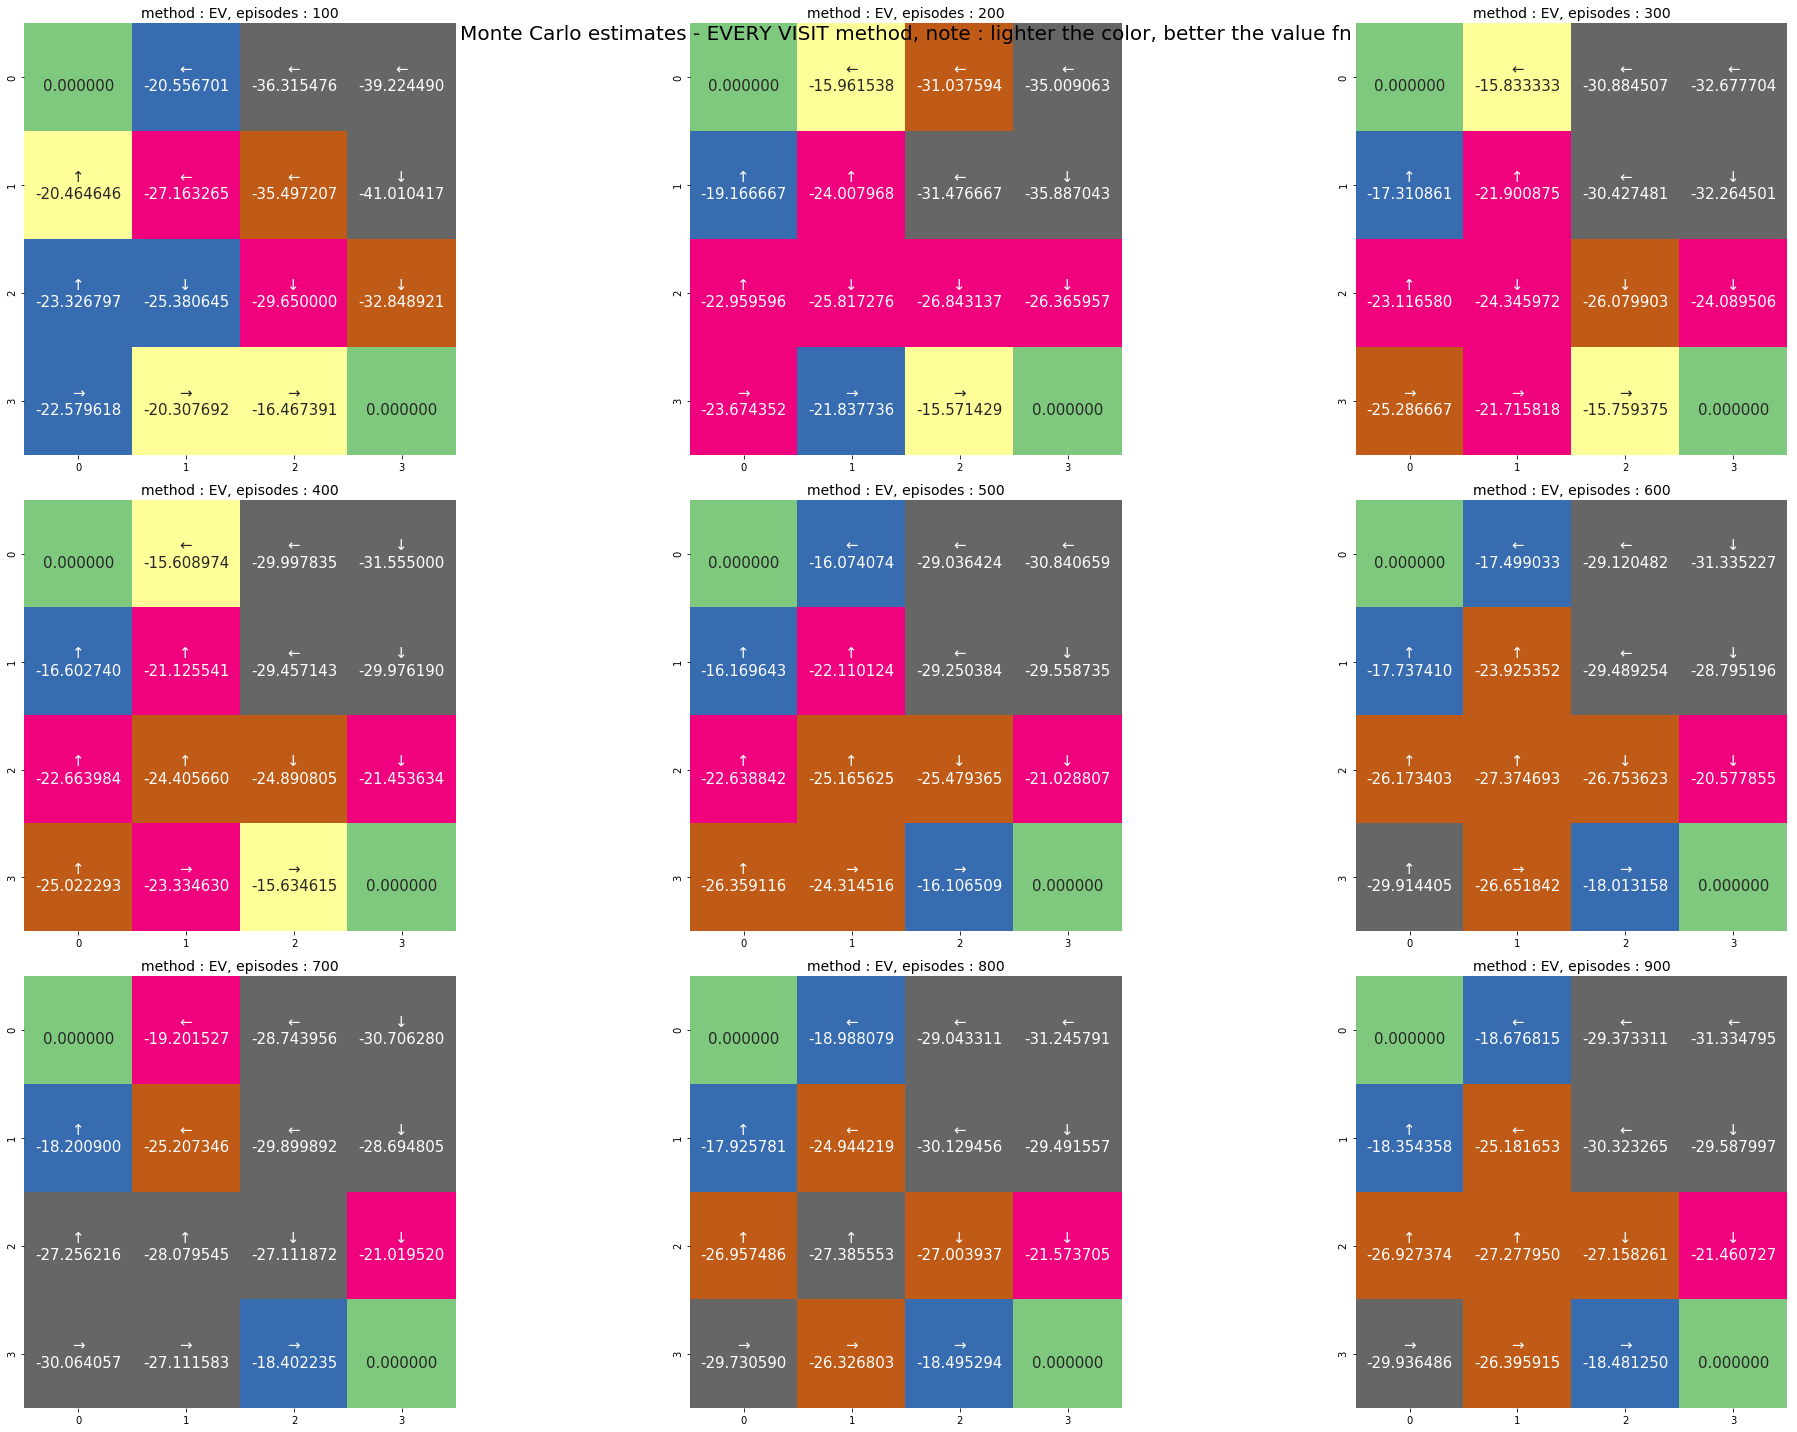

In [20]:
nbr_cycles_of_MC_run    = 9
nbr_episodes_each_cycle = 100
number_plots_per_row    = 3

EV_V = dict()
EV_policy = dict()
EV_policy_dirs_chars = dict()

fig, ax = plt.subplots(nrows=nbr_cycles_of_MC_run//number_plots_per_row, ncols=number_plots_per_row, figsize=(30, 20))

fig.suptitle('Monte Carlo estimates - EVERY VISIT method, note : lighter the color, better the value fn\n\n', fontsize=20)

values  = value_array(gw)
returns = dict()

for state in gw.states:
    returns[state] = list()

for cycle in range(nbr_cycles_of_MC_run):

    for i in range(nbr_episodes_each_cycle):
        episode = generate_random_episode(gw)
        
        for s, r in episode:
            if s != 0:    # exclude terminal state (0)
                idx = episode.index((s, r))
                G = 0
                j = 1
                while j + idx < len(episode):
                    G = gw.gamma * (G + episode[j + idx][1])
                    j += 1
                    
                returns[s].append(G)
                values[s] = np.mean(returns[s])

    V = np.array(values).reshape(4,4)
    policy, all_dirs_chars = gw.get_policy(V)

    EV_V['EV-'+str((cycle+1)*nbr_episodes_each_cycle)] = V
    EV_policy['EV-'+str((cycle+1)*nbr_episodes_each_cycle)] = policy
    EV_policy_dirs_chars['EV-'+str((cycle+1)*nbr_episodes_each_cycle)] = all_dirs_chars

    sns.heatmap(V, 
            annot=policy, 
            fmt='', 
            cbar=False,
            square=True, 
            cmap='Accent_r',
            annot_kws={"size":15},
            ax=ax[cycle//number_plots_per_row, cycle%number_plots_per_row]
            )

    ax[cycle//number_plots_per_row, cycle%number_plots_per_row].set_title('method : EV, episodes : {}'.format(str((cycle+1)*nbr_episodes_each_cycle)), fontsize=14)

plt.tight_layout()

#### Compare FV and EV

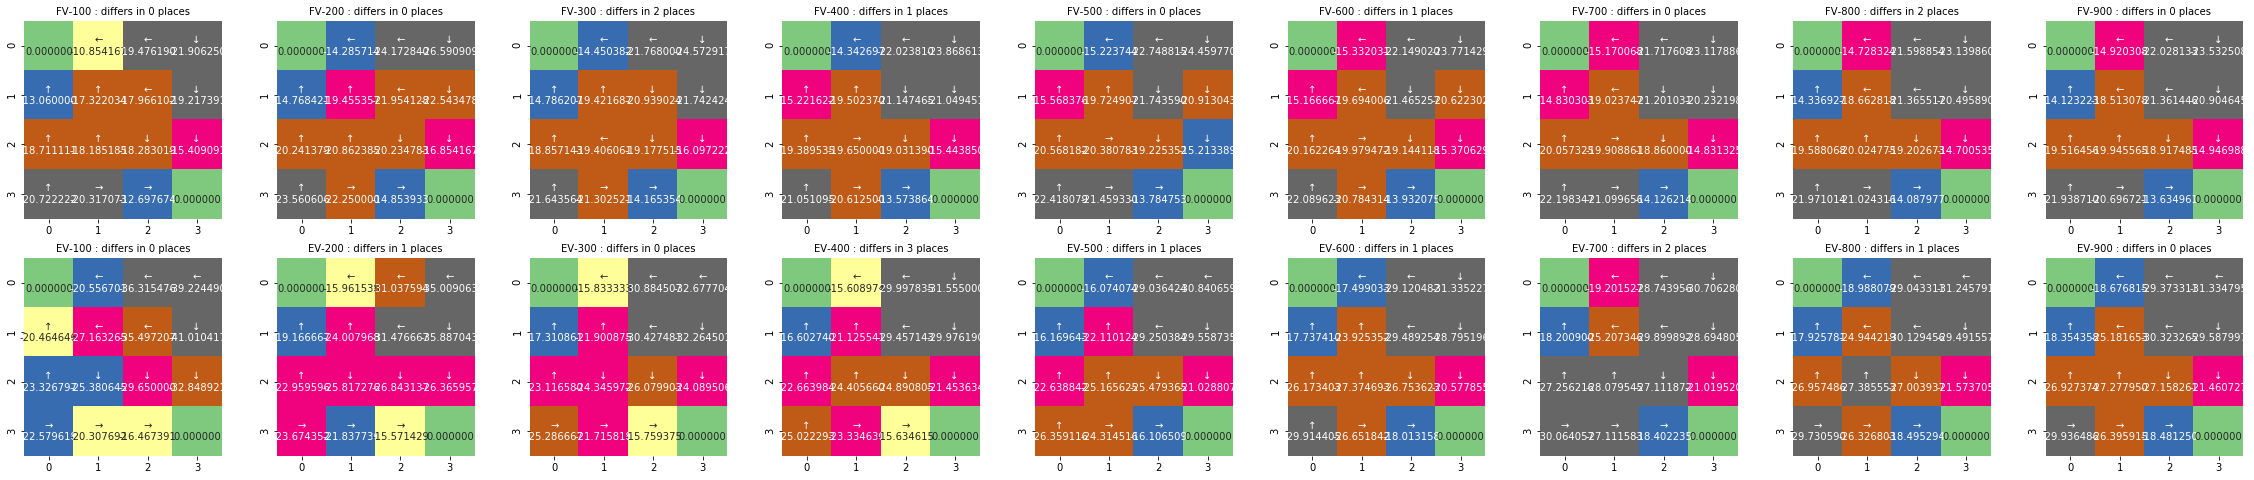

In [21]:
FV_keys = list(FV_policy.keys())
EV_keys = list(EV_policy.keys())

fig, ax = plt.subplots(nrows=2, ncols=nbr_cycles_of_MC_run, figsize=(40, 8))

for key in range(len(EV_keys)):
    EV_key = EV_keys[key]
    FV_key = FV_keys[key]

    EV_policy_dirs_chars_list = EV_policy_dirs_chars[EV_key]
    FV_policy_dirs_chars_list = FV_policy_dirs_chars[FV_key]

    if key == 0:
        EV_policy_dirs_chars_list_prev = EV_policy_dirs_chars_list
        FV_policy_dirs_chars_list_prev = FV_policy_dirs_chars_list

    FV_differ_count = 0
    EV_differ_count = 0

    for dir1, dir2 in zip(EV_policy_dirs_chars_list, EV_policy_dirs_chars_list_prev):
        if dir1 != dir2:
            EV_differ_count +=1

    for dir1, dir2 in zip(FV_policy_dirs_chars_list, FV_policy_dirs_chars_list_prev):
        if dir1 != dir2:
            FV_differ_count +=1
    
    sns.heatmap(FV_V[FV_key], 
                annot=FV_policy[FV_key], 
                fmt='', 
                cbar=False,
                square=True, 
                cmap='Accent_r',
                annot_kws={"size":10},
                ax=ax[0, key]
            )

    ax[0, key].set_title(FV_key+' : differs in {} places'.format(FV_differ_count), fontsize=10)

    sns.heatmap(EV_V[EV_key], 
                annot=EV_policy[EV_key], 
                fmt='', 
                cbar=False,
                square=True, 
                cmap='Accent_r',
                annot_kws={"size":10},
                ax=ax[1, key]
            )

    ax[1, key].set_title(EV_key+' : differs in {} places'.format(EV_differ_count), fontsize=10)

    EV_policy_dirs_chars_list_prev = EV_policy_dirs_chars_list
    FV_policy_dirs_chars_list_prev = FV_policy_dirs_chars_list        